In [ ]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from scipy.stats import mode
from sklearn.model_selection import GroupKFold
from sklearn.metrics import f1_score
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# PyTorch
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Numpy
np.random.seed(seed)


In [ ]:
label_encoder = LabelEncoder()

In [ ]:
def split_data_leave_one_out(df_label, subject_col, n_splits=5):
    """
       Splits the input DataFrame into training and test sets using Group K-Fold cross-validator.

       Args:
           df_label (pd.DataFrame): The input DataFrame with labels.
           subject_col (str): The column name containing the subject identifiers.
           n_splits (int, optional): The number of splits for the cross-validation. Defaults to 5.

       Returns:
           iterator: An iterator over the indices of the training and test sets.
       """

    groups = df_label[subject_col]  # normal is the id of subject.
    gkf = GroupKFold(n_splits=n_splits)
    gkf.get_n_splits(df_label, groups=groups)
    cv = gkf.split(df_label, groups=groups)
    return cv

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/WISDM_ar_v1.1_raw.txt',sep=",", names=['id','target','timestamp','sensor_0','sensor_1','sensor_2'])
df.drop(columns=['timestamp'], inplace=True)

df = df[1:]

y = label_encoder.fit_transform(df['target'])
X = df.drop(columns=['target'])
X.dropna(axis=0, how='any', inplace=True)

print(X['id'].dtype)
print(X['id'].head())

X = X.apply(pd.to_numeric, errors='coerce')
X = X.dropna()
X['id'] = X['id'].astype(int)


<ipython-input-24-a3ec2723db58>:1: DtypeWarning: Columns (0,2,3,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/drive/MyDrive/WISDM_ar_v1.1_raw.txt',sep=",", names=['id','target','timestamp','sensor_0','sensor_1','sensor_2'])


object
1    33
2    33
3    33
4    33
5    33
Name: id, dtype: object


In [ ]:
class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h_0 = torch.zeros(1, x.size(0), hidden_dim).to('cuda')
        c_0 = torch.zeros(1, x.size(0), hidden_dim).to('cuda')
        out, _ = self.lstm(x, (h_0, c_0))
        out = self.fc(out[:, -1, :])
        return out


In [ ]:
input_dim = 3
hidden_dim  = 50
output_dim = 6
lstm_model = LSTMClassifier(input_dim,hidden_dim,output_dim).to('cuda')

In [ ]:
print(torch.cuda.is_available())
print(next(lstm_model.parameters()).device)


True
cuda:0


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)

In [ ]:
def to_tensor(v, step,v_type=torch.float32):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  num_rows = v.shape[0]
  num_features = v.shape[1]

  v_num_new_rows = num_rows - num_rows % step
  v = v[:v_num_new_rows]

  v = torch.tensor(v.values, dtype=v_type).view(-1, step, num_features).to(device)
  print(v_num_new_rows)
  print(f"v.shape[0] is: {v.shape[0]}")
  return v,v_num_new_rows


In [ ]:
def y_mode_select(y_tensor,step,y_type=torch.int64):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  y_tensor = torch.tensor(y_tensor,dtype=y_type).view(-1,step,1)
  y_tensor = mode(y_tensor,axis=1)[0].squeeze()
  return torch.tensor(y_tensor,dtype=y_type).to('cuda')

In [ ]:
def train_y_test_y_to_tensor(y_train,y_test,y_train_index, y_test_index,step,y_type=torch.int64):
  y_train = y_train[:y_train_index]
  y_test = y_test[:y_test_index]
  return y_mode_select(y_train,step,y_type),y_mode_select(y_test,step,y_type)

In [ ]:
def train_X_test_X_to_tensor(X_train, X_test, step):
    tensor_X_train, new_rows_train = to_tensor(X_train, step)
    tensor_X_test, new_rows_test = to_tensor(X_test, step)
    return tensor_X_train, new_rows_train, tensor_X_test, new_rows_test

In [ ]:
cv = split_data_leave_one_out(X,'id',n_splits=6)
f1_scores = []
loss_groups = []
for train_index, test_index in cv:
  print(train_index)
  print(test_index)
  X_train = X.loc[X.index.isin(train_index), :]
  X_test = X.loc[X.index.isin(test_index), :]
  X_train = X_train.drop(columns=['id'])
  X_test = X_test.drop(columns=['id'])

  X_train,X_train_new_rows,X_test,X_test_new_rows = train_X_test_X_to_tensor(X_train,X_test,60)
  y_train, y_test = y[train_index],y[test_index]
  y_train,y_test = train_y_test_y_to_tensor(y_train,y_test,X_train_new_rows, X_test_new_rows,60)
  current_loss_group = []
  for epoch in range(100):
      optimizer.zero_grad()
      output = lstm_model(X_train)
      loss = criterion(output, y_train)
      loss.backward()
      optimizer.step()
      current_loss_group.append(loss.item())

      if epoch % 10 == 0:
          print(f'Epoch [{epoch+1}/100], Loss: {loss.item()}')
  loss_groups.append(current_loss_group)
  with torch.no_grad():
        output = lstm_model(X_test)
        _, predicted = torch.max(output, 1)
        predicted = predicted.cpu().numpy()
        y_test = y_test.cpu().numpy()

        f1 = f1_score(y_test, predicted, average='weighted')
        f1_scores.append(f1)

[      0       1       2 ... 1098205 1098206 1098207]
[ 14353  14354  14355 ... 941961 941962 941963]
913080
v.shape[0] is: 15218
185040
v.shape[0] is: 3084
Epoch [1/100], Loss: 1.766185998916626
Epoch [11/100], Loss: 1.596914291381836
Epoch [21/100], Loss: 1.4679514169692993
Epoch [31/100], Loss: 1.373212456703186
Epoch [41/100], Loss: 1.2755476236343384
Epoch [51/100], Loss: 1.139116883277893
Epoch [61/100], Loss: 0.9478225708007812
Epoch [71/100], Loss: 0.8258438110351562
Epoch [81/100], Loss: 0.7695421576499939
Epoch [91/100], Loss: 0.7287854552268982
[      0       1       2 ... 1052822 1052823 1052824]
[ 225064  225065  225066 ... 1098205 1098206 1098207]
920400
v.shape[0] is: 15340
177720
v.shape[0] is: 2962
Epoch [1/100], Loss: 0.7625904679298401
Epoch [11/100], Loss: 0.7011552453041077
Epoch [21/100], Loss: 0.6572807431221008
Epoch [31/100], Loss: 0.6084972023963928
Epoch [41/100], Loss: 0.5649370551109314
Epoch [51/100], Loss: 0.5219178199768066
Epoch [61/100], Loss: 0.479871

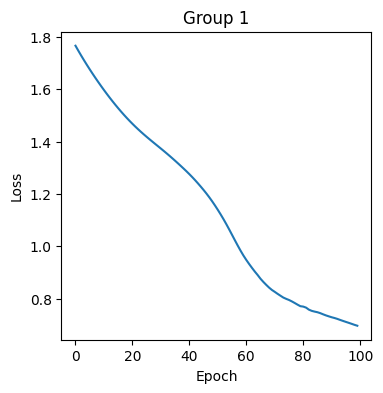

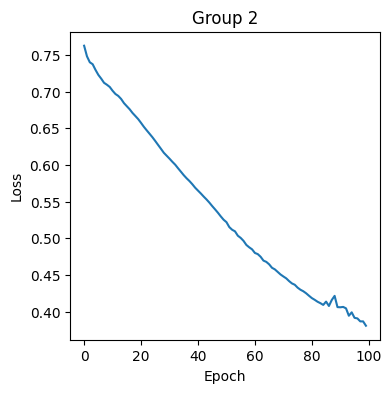

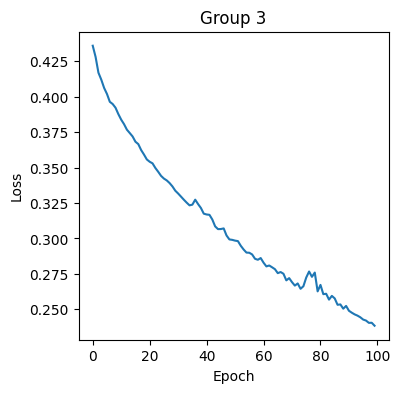

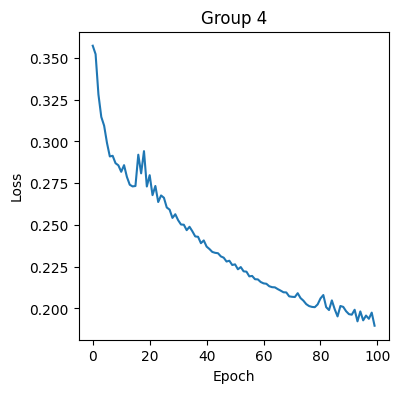

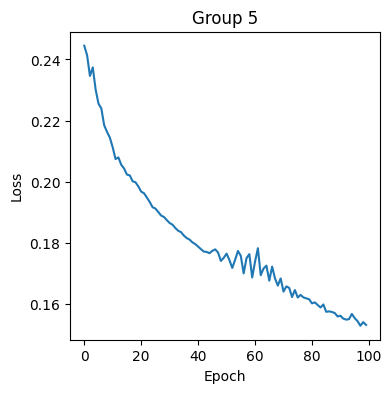

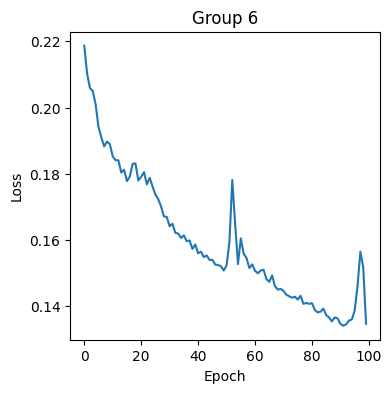

In [ ]:
for i, loss_group in enumerate(loss_groups):
    plt.figure(figsize=(4,4))
    plt.plot(range(len(loss_group)), loss_group)
    plt.title(f'Group {i+1}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

In [ ]:
import numpy as np
average_f1_score = np.mean(f1_scores)
print(f"Average F1 Score: {average_f1_score}")

Average F1 Score: 0.816160380753923
